In [1]:
import sys
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

In [2]:
%matplotlib inline
import os
import cv2
import glob
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import metrics

from efficientnet_pytorch.model import EfficientNet


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
sns.__version__

'0.10.0'

## Data

In [4]:
os.listdir('/kaggle/input/cassava-leaf-disease-classification')

['train_tfrecords',
 'train_images',
 'test_tfrecords',
 'sample_submission.csv',
 'label_num_to_disease_map.json',
 'train.csv',
 'test_images']

In [5]:
data_dir = '/kaggle/input/cassava-leaf-disease-classification'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [6]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
sub.head()

,image_id,label
0,2216849948.jpg,4


## Seed Setting

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## Label Distribution

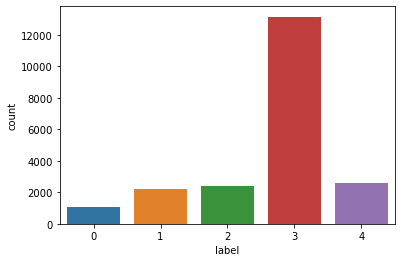

In [9]:
sns.countplot(x='label', data=train)
plt.show()

In [10]:
train['label'].value_counts().sort_index()

0     1087
1     2189
2     2386
3    13158
4     2577
Name: label, dtype: int64

## Dataset

In [11]:
class CassavaDataset(Dataset):
    def __init__(self, data_dir, transform=None, phase='train', df=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.phase = phase
        if self.phase == 'test':
            img_dir = 'test_images'
        else:
            img_dir = 'train_images'
        self.img_path = glob.glob(os.path.join(self.data_dir, img_dir, '*.jpg'))

    def __len__(self):
        if self.df is None:
            return len(self.img_path)
        else:
            return len(self.df)

    def __getitem__(self, idx):
        
        if self.phase == 'test':
            target_img_path = self.img_path[idx]
        else:
            row = self.df.iloc[idx]
            target_img_id = row['image_id']
            target_img_path = os.path.join(self.data_dir, 'train_images', f'{target_img_id}')
            
        img = cv2.imread(target_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = os.path.basename(target_img_path)

        if self.transform is not None:
            img = self.transform(img, self.phase)
        else:
            img = torch.from_numpy(img.transpose((2, 0, 1)))
            img = img / 255.

        if self.phase == 'test':
            return img, img_id
        
        else:
            label = self.df[self.df['image_id'] == img_id]['label'].values
            label = torch.tensor(label, dtype=torch.long)

            return img, label

## ImageTransform

In [12]:
class ImageTransform:
    def __init__(self, img_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.transform = {
            'train': albu.Compose([
                albu.Resize(img_size, img_size),
                albu.HorizontalFlip(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.Normalize(mean, std),
                ToTensorV2(),
            ], p=1.0),

            'val': albu.Compose([
                albu.Resize(img_size, img_size),
                albu.Normalize(mean, std),
                ToTensorV2(),
            ], p=1.0),

            'test': albu.Compose([
                albu.Resize(img_size, img_size),
                albu.Normalize(mean, std),
                ToTensorV2(),
            ], p=1.0)
        }

    def __call__(self, img, phase='train'):
        augmented = self.transform[phase](image=img)
        augmented = augmented['image']

        return augmented

In [13]:
# Sanity Check
transform = ImageTransform()
dataset = CassavaDataset(data_dir, transform, phase='train', df=train)
img, label = dataset.__getitem__(0)
print(img.size(), label)
print(img.max())
print(img.min())

torch.Size([3, 224, 224]) tensor([0])
tensor(2.6400)
tensor(-2.1179)


In [14]:
dataloader = DataLoader(dataset, batch_size=8)

imgs, labels = next(iter(dataloader))
print(imgs.size())

torch.Size([8, 3, 224, 224])


In [15]:
# Sanity Check
transform = ImageTransform()
dataset = CassavaDataset(data_dir, transform, phase='test', df=None)
img, label = dataset.__getitem__(0)
print(img.size(), label)
print(img.max())
print(img.min())

torch.Size([3, 224, 224]) 2216849948.jpg
tensor(2.6400)
tensor(-2.1179)


In [16]:
dataloader = DataLoader(dataset, batch_size=1)

imgs, labels = next(iter(dataloader))
print(imgs.size())

torch.Size([1, 3, 224, 224])


## Lightning DataModule

In [17]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, cfg, transform, cv):
        super(CassavaDataModule, self).__init__()
        self.data_dir = data_dir
        self.cfg = cfg
        self.transform = transform
        self.cv = cv


    def prepare_data(self):
        # Prepare Data
        self.df = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))


    def setup(self, stage=None):
        # Validation
        self.df['fold'] = -1
        for i, (trn_idx, val_idx) in enumerate(self.cv.split(self.df, self.df['label'])):
            self.df.loc[val_idx, 'fold'] = i
        fold = self.cfg.train['fold']
        train = self.df[self.df['fold'] != fold].reset_index(drop=True)
        val = self.df[self.df['fold'] == fold].reset_index(drop=True)
        
        # Dataset
        self.train_dataset = CassavaDataset(self.data_dir, self.transform, phase='train', df=train)
        self.val_dataset = CassavaDataset(self.data_dir, self.transform, phase='val', df=val)
        self.test_dataset = CassavaDataset(self.data_dir, self.transform, phase='test', df=None)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.cfg.train['batch_size'],
                          pin_memory=False,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.cfg.train['batch_size'],
                          pin_memory=False,
                          shuffle=False)

    def test_dataloader(self):
        batch_size = min(len(self.test_dataset), self.cfg.train['batch_size'])
        return DataLoader(self.test_dataset,
                          batch_size=batch_size,
                          pin_memory=False,
                          shuffle=False)

## Model

In [18]:
pretrained_model = {
    'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth',
    'efficientnet-b1': '../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth',
    'efficientnet-b2': '../input/efficientnet-pytorch/efficientnet-b2-27687264.pth',
    'efficientnet-b3': '../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth',
    'efficientnet-b4': '../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth',
    'efficientnet-b5': '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth',
    'efficientnet-b7': '../input/efficientnet-pytorch/efficientnet-b7-dcc49843.pth',
}

class MyNet(nn.Module):
    def __init__(self, model_type='efficientnet-b0', pretrained=True, out_dim=5):
        super(MyNet, self).__init__()
        self.base = EfficientNet.from_name(model_type)
        if pretrained:
            self.base.load_state_dict(torch.load(pretrained_model[model_type]))
            self.myfc = nn.Linear(self.base._fc.in_features, out_dim)
            self.base._fc = nn.Identity()
            
    def forward(self, x):
        x = self.base(x)
        out = self.myfc(x)
        return out

In [19]:
# Sanity Check
z = torch.randn(4, 3, 224, 224)
model = MyNet()
out = model(z)
print(out.size())

torch.Size([4, 5])


## Lightning Module

In [20]:
class CassavaLightningSystem(pl.LightningModule):
    def __init__(self, net, cfg, experiment=None):
        super(CassavaLightningSystem, self).__init__()
        self.net = net
        self.cfg = cfg
        self.experiment = experiment
        self.criterion = nn.CrossEntropyLoss()
        self.best_loss = 1e+9
        self.best_acc = None
        self.epoch_num = 0
        self.acc_fn = metrics.Accuracy()
        self.loss_list = []
        self.acc_list = []

    def configure_optimizers(self):
        self.optimizer = optim.AdamW(self.parameters(), lr=self.cfg.train['lr'], weight_decay=2e-5)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.cfg.train['epoch'], eta_min=0)

        return [self.optimizer], [self.scheduler]

    def forward(self, x):
        return self.net(x)

    def step(self, batch):
        inp, label = batch
        out = self.forward(inp)
        loss = self.criterion(out, label.squeeze())

        return loss, label, torch.sigmoid(out)

    def training_step(self, batch, batch_idx):
        loss, label, logits = self.step(batch)

        if self.experiment is not None:
            logs = {'train/loss': loss.item()}
            self.experiment.log_metrics(logs, step=batch_idx)

        return {'loss': loss, 'logits': logits, 'labels': label}

    def validation_step(self, batch, batch_idx):
        loss, label, logits = self.step(batch)

        if self.experiment is not None:
            val_logs = {'val/loss': loss.item()}
            self.experiment.log_metrics(val_logs, step=batch_idx)

        return {'val_loss': loss, 'logits': logits, 'labels': label}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        logits = torch.cat([x['logits'] for x in outputs])
        labels = torch.cat([x['labels'] for x in outputs])
        
        # Accuracy
        acc = self.acc_fn(logits, labels.squeeze())
                
        print(f'Epoch: {self.epoch_num}  Loss: {avg_loss.item():.4f}  Acc {acc.item():.4f}')
        self.loss_list.append(avg_loss.item())
        self.acc_list.append(acc.item())
        
        if self.experiment is not None:
            logs = {'val/epoch_loss': avg_loss, 'val/epoch_acc': acc}
            # Logging
            self.experiment.log_metrics(logs, step=self.epoch_num)

        # Save Weights
        if self.best_loss > avg_loss:
            self.best_loss = avg_loss.item()
            self.best_acc = acc.item()
            expname = self.cfg.exp['exp_name']
            filename = f'{expname}_epoch_{self.epoch_num}_loss_{self.best_loss:.3f}_acc_{self.best_acc:.3f}.pth'
            torch.save(self.net.state_dict(), filename)
            if self.experiment is not None:
                self.experiment.log_model(name=filename, file_or_folder='./'+filename)
                os.remove(filename)
            
        # Update Epoch Num
        self.epoch_num += 1

        return {'avg_val_loss': avg_loss}

    def test_step(self, batch, batch_idx):
        inp, img_id = batch
        out = self.forward(inp)
        logits = torch.sigmoid(out)

        return {'preds': logits, 'image_id': img_id}

    def test_epoch_end(self, outputs):
        preds = torch.cat([x['preds'] for x in outputs])        
        _, preds = torch.max(preds, 1)
        
        preds = preds.detach().cpu().numpy()
        # [tuple, tuple]
        img_ids = [x['image_id'] for x in outputs]
        # [list, list]
        img_ids = [list(x) for x in img_ids]
        img_ids = list(itertools.chain.from_iterable(img_ids))

        self.sub = pd.DataFrame({
            'image_id': img_ids,
            'label': preds
        })
        
        self.sub.to_csv('submission.csv', index=False)

        return None

## Config

In [21]:
class cfg:
    exp = {
        'exp_name': 'test'
    }
    
    data = {
        'img_size': 256
    }
    
    train = {
        'batch_size': 32,
        'epoch': 20,
        'seed': 42,
        'fold': 0,
        'lr': 0.003,
        'model_type': 'efficientnet-b0'
    }

## Trainer

In [22]:
# Data Dir  #################################################################
data_dir = '/kaggle/input/cassava-leaf-disease-classification'
seed_everything(cfg.train['seed'])

# Validation  ###############################################################
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.train['seed'])

# Model  ####################################################################
net = MyNet(model_type=cfg.train['model_type'])
transform = ImageTransform(img_size=cfg.data['img_size'])


# Lightning Module  #########################################################
model = CassavaLightningSystem(net, cfg, experiment=None)
dm = CassavaDataModule(data_dir, cfg, transform, cv)

checkpoint_callback = ModelCheckpoint(
    filepath='.',
    save_top_k=1,
    verbose=True,
    monitor='avg_val_loss',
    mode='min',
    prefix=cfg.exp['exp_name'] + '_'
)

trainer = Trainer(
    logger=False,
    max_epochs=cfg.train['epoch'],
    checkpoint_callback=checkpoint_callback,
    gpus=1
        )

# Train & Test  ############################################################
# Train
trainer.fit(model, datamodule=dm)

# Test
trainer.test(model, datamodule=dm)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory . exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | MyNet            | 4 M   
1 | criterion | CrossEntropyLoss | 0     
2 | acc_fn    | Accuracy         | 0     


Epoch: 0  Loss: 1.6047  Acc 0.2031


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


Epoch 0: avg_val_loss reached 0.86977 (best 0.86977), saving model to /kaggle/working/test_-epoch=0.ckpt as top 1


Epoch: 1  Loss: 0.8698  Acc 0.7402


Epoch 1: avg_val_loss reached 0.72886 (best 0.72886), saving model to /kaggle/working/test_-epoch=1.ckpt as top 1


Epoch: 2  Loss: 0.7289  Acc 0.7979


Epoch 2: avg_val_loss reached 0.61910 (best 0.61910), saving model to /kaggle/working/test_-epoch=2.ckpt as top 1


Epoch: 3  Loss: 0.6191  Acc 0.7888


Epoch 3: avg_val_loss was not in top 1


Epoch: 4  Loss: 1.1150  Acc 0.6523


Epoch 4: avg_val_loss reached 0.55126 (best 0.55126), saving model to /kaggle/working/test_-epoch=4.ckpt as top 1


Epoch: 5  Loss: 0.5513  Acc 0.8079


Epoch 5: avg_val_loss reached 0.50694 (best 0.50694), saving model to /kaggle/working/test_-epoch=5.ckpt as top 1


Epoch: 6  Loss: 0.5069  Acc 0.8248


Epoch 6: avg_val_loss reached 0.50424 (best 0.50424), saving model to /kaggle/working/test_-epoch=6.ckpt as top 1


Epoch: 7  Loss: 0.5042  Acc 0.8313


Epoch 7: avg_val_loss was not in top 1


Epoch: 8  Loss: 0.5550  Acc 0.8262


Epoch 8: avg_val_loss reached 0.46448 (best 0.46448), saving model to /kaggle/working/test_-epoch=8.ckpt as top 1


Epoch: 9  Loss: 0.4645  Acc 0.8542


Epoch 9: avg_val_loss reached 0.45436 (best 0.45436), saving model to /kaggle/working/test_-epoch=9.ckpt as top 1


Epoch: 10  Loss: 0.4544  Acc 0.8500


Epoch 10: avg_val_loss was not in top 1


Epoch: 11  Loss: 0.4617  Acc 0.8442


Epoch 11: avg_val_loss reached 0.45036 (best 0.45036), saving model to /kaggle/working/test_-epoch=11.ckpt as top 1


Epoch: 12  Loss: 0.4504  Acc 0.8551


Epoch 12: avg_val_loss was not in top 1


Epoch: 13  Loss: 0.4530  Acc 0.8505


Epoch 13: avg_val_loss was not in top 1


Epoch: 14  Loss: 0.4509  Acc 0.8624


Epoch 14: avg_val_loss was not in top 1


Epoch: 15  Loss: 0.4751  Acc 0.8584


Epoch 15: avg_val_loss was not in top 1


Epoch: 16  Loss: 0.4919  Acc 0.8500


Epoch 16: avg_val_loss was not in top 1


Epoch: 17  Loss: 0.4937  Acc 0.8561


Epoch 17: avg_val_loss was not in top 1


Epoch: 18  Loss: 0.4971  Acc 0.8570


Epoch 18: avg_val_loss was not in top 1


Epoch: 19  Loss: 0.5113  Acc 0.8603


Epoch 19: avg_val_loss was not in top 1


Epoch: 20  Loss: 0.5144  Acc 0.8577



--------------------------------------------------------------------------------



1

## Learning Plot

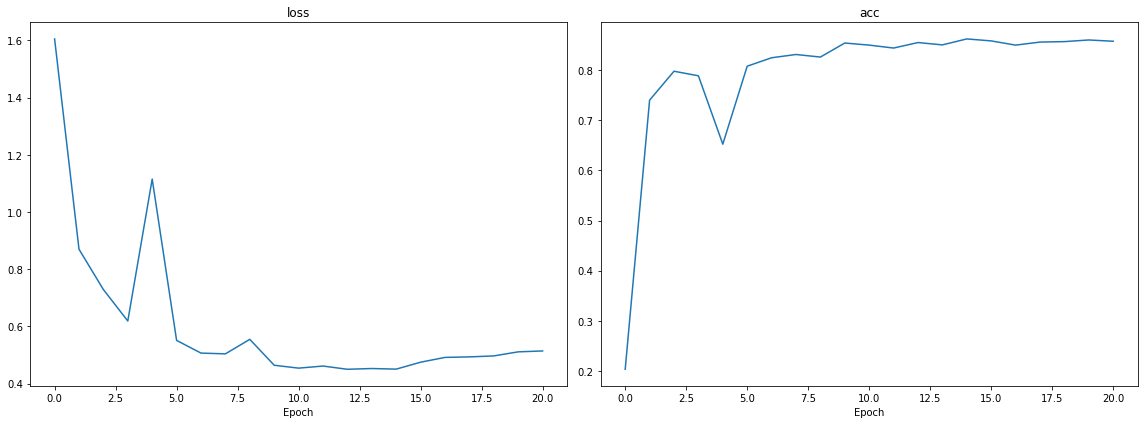

In [23]:
history = pd.DataFrame({
    'loss': model.loss_list,
    'acc': model.acc_list
})

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

for ax, label in zip(axes.ravel(), ['loss', 'acc']):
    ax.plot(history[label])
    ax.set_title(label)
    ax.set_xlabel('Epoch')

plt.tight_layout()
plt.show()